In [65]:
### Connect using gspread

import gspread

gc = gspread.service_account(filename = 'Babysleep-tryout-client-secret.json')

# get the instance of the Spreadsheet
sheet = gc.open('Babysleep-diaries_18.01.21-19.02.21')

In [67]:
import regex as re
import pandas as pd
import gspread_dataframe as gd

# prepare a list with all sheet names from the spreadsheet and select the part of the statement,
# that function worksheets writes, that contains only the actual sheet name

sheet_names = []
for name in sheet.worksheets():
    #print(str(name))
    sheet_names.append(re.findall(r"'(.*?)'", str(name))[0])
print(sheet_names)

dict_df = {}
for name in sheet_names:
    sheet_instance = sheet.worksheet(name)
    dict_df[name] = gd.get_as_dataframe(sheet_instance,evaluate_formulas = True,skiprows = 1, has_header = True)

['1. Иванова Анна (Яна)', '2. Петрова Алена (Вероника)', '3. Сидорова Анастасия (Нина)', '4. Николаевы Варвара и Антон (Ия)', '5. Шевченко Наталья (Демьян)']


In [37]:
# How to write columns from one DF to another, if they are both in the dictionaries

dict_col1 = {}

columns1 = ['Дата ', 
            'УТРО (проснулись)', 
            'ВРЕМЯ засыпания в НОЧЬ (пережолили / отпустил грудь / вышли из комнаты и т.п.)', 
            'Кол-во ночных проб-й']
columns2 = ['Date', 
            'First wake up time', 
            'Sleep starting time', 
            'Nr of night wake ups']

for key, value in dict_df.items():
    dict_col1[key] = value.loc[:,columns1]
    print(dict_col1[key].shape)

dict_col2 = {}
for name in sheet_names:
    dict_col2[name] = dict_df[name].loc[:,columns1]
    dict_col2[name].columns = columns2
    print(dict_col2[name].columns)

(967, 4)
(967, 4)
(967, 4)
(967, 4)
(967, 4)
Index(['Date', 'First wake up time', 'Sleep starting time',
       'Nr of night wake ups'],
      dtype='object')
Index(['Date', 'First wake up time', 'Sleep starting time',
       'Nr of night wake ups'],
      dtype='object')
Index(['Date', 'First wake up time', 'Sleep starting time',
       'Nr of night wake ups'],
      dtype='object')
Index(['Date', 'First wake up time', 'Sleep starting time',
       'Nr of night wake ups'],
      dtype='object')
Index(['Date', 'First wake up time', 'Sleep starting time',
       'Nr of night wake ups'],
      dtype='object')


In [38]:
def create_dc(dc, list1, list2):
    """ Creates a new dictionary with DataFrames from an existing dictionary dc.
    From df1 data from columns from list1 will be copied. The columns in the new DataFrame
    wil be called according to the list2. The order of the names must be the same in list1 and list2.
    """
    dc2 = {}
    for key, value in dc.items():
        dc2[key] = value.loc[:, list1]
        dc2[key].columns = list2
    return dc2

columns1 = ['Дата ', 
            'УТРО (проснулись)', 
            'ВРЕМЯ засыпания в НОЧЬ (пережолили / отпустил грудь / вышли из комнаты и т.п.)', 
            'Кол-во ночных проб-й']
columns2 = ['Date', 
            'First wake up time', 
            'Sleep starting time', 
            'Nr of night wake ups']

dict_dc_vis = create_dc(dict_df, columns1, columns2)
                 
for key, value in dict_dc_vis.items():
    print(value.shape)
    

for value in dict_dc_vis.values():
    value['Nr of night wake ups'] = value['Nr of night wake ups'].astype(int)

(967, 4)
(967, 4)
(967, 4)
(967, 4)
(967, 4)


In [ ]:
for value in dict_dc_vis.values():
    print('Shape before dropna: ', value.shape)
    icof value.isnull().values.any():
        value.dropna(axis=0, how='any', inplace=True)
        print('Shape after dropna: ', value.shape)

In [88]:
# alternative filter dor dictionary with dictionary comprehension
# https://blog.finxter.com/how-to-filter-a-dictionary-in-python/
# print({x for x in v for v in dict_dc_vis.values()})

NameError: name 'v' is not defined

In [76]:
### insert a comment, if condition

new_column = 'New_Column'
filter_col = 'Nr of night wake ups'
comment = 'New test comment'

for value in dict_dc_vis.values():
    value[new_column] = ''
    filter1 = value[filter_col] < 4
    value.loc[filter1, 'Comment'] = comment
    print(value)

        Date First wake up time Sleep starting time  Nr of night wake ups  \
0   18.01.21               6:10               21:00                     5   
1   19.01.21               8:55               20:50                     3   
2   20.01.21               7:20               21:17                     3   
3   21.01.21               7:20               20:55                     4   
4   22.01.21               7:07               20:55                     3   
5   23.01.21               6:42               21:00                     2   
6   24.01.21               7:19               21:33                     2   
7   25.01.21               7:35               22:00                     2   
8   26.01.21               7:05               21:32                     5   
9   27.01.21               7:30               21:29                     3   
10  28.01.21               7:02               21:49                     6   
11  29.01.21               7:21               21:29                     3   

In [74]:
"""
def write_comment(dic, filter1, name_of_column, comment):
    for value in dic.values():
        value[name_of_column] = ''
        value.loc[filter1, name_of_column] = comment   

write_comment(dict_dc_vis, filter1, 'New_comment', 'Test comment 2')
print(dict_dc_vis.info"""
"""

IndexingError: (0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11    False
12     True
13    False
14    False
15    False
16    False
17     True
29    False
30     True
31    False
Name: Nr of night wake ups, dtype: bool, 'New_comment')

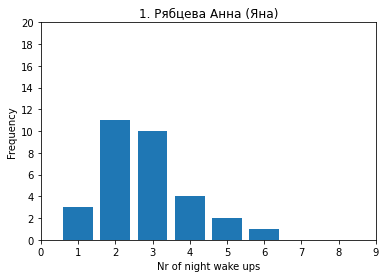

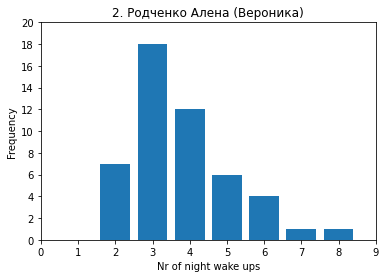

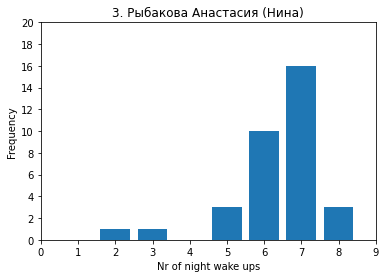

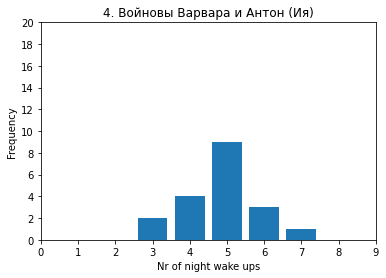

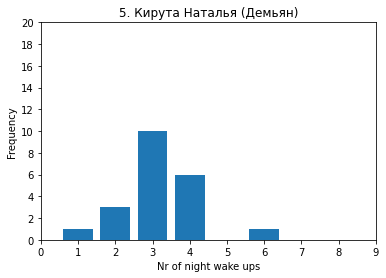

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dict_dc_vis_group = {} 
for key, value in dict_dc_vis.items():
    dict_dc_vis_group[key] = value.groupby('Nr of night wake ups', as_index=False).count()
    plt.bar(x='Nr of night wake ups', height='Date', data=dict_dc_vis_group[key])
    plt.xlim(0, 9)
    #plt.xticks(np.arange(0, 8, 1))
    plt.yticks(np.arange(0, 21, 2))
    plt.xlabel('Nr of night wake ups')
    plt.ylabel('Frequency')
    plt.title(key)
    plt.show()